In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\rober\AppData\Local\Temp\ipykernel_159256\1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date in the dataset: {recent_date}")

Most recent date in the dataset: 2017-08-23


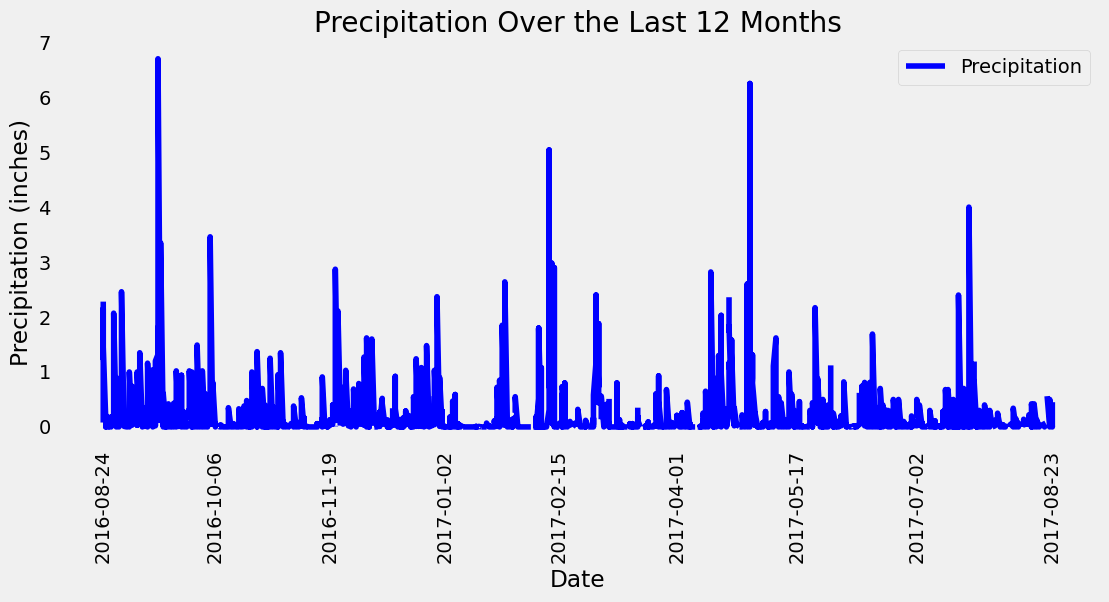

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d") #convert recent_date string to datetime
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precip_df.set_index("Date", inplace=True)


# Define the number of ticks to display
num_ticks = 9  # Adjust this number if needed

# Convert the index (dates) to datetime format for better handling
precip_df.index = pd.to_datetime(precip_df.index)

# Select evenly spaced date indices for x-axis labels
tick_indices = np.linspace(0, len(precip_df.index) - 1, num_ticks, dtype=int)
tick_labels = [precip_df.index[i].strftime('%Y-%m-%d') for i in tick_indices]

# Plot the precipitation data
plt.figure(figsize=(12, 5))
plt.plot(precip_df.index, precip_df["Precipitation"], label="Precipitation", color="blue")

# Apply the fixed x-ticks
plt.xticks(tick_labels, rotation=90)

# Labeling the plot
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.legend()
plt.grid()

# Show the plot
# plt.savefig
plt.show()


In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df.describe()

print(precip_summary)


       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"the total number of sations: {total_stations}")


the total number of sations: 9


In [67]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

print("Most active stations:")
for station, count in active_stations:
    print(f"Station {station}: {count} observations")


Most active stations:
Station USC00519281: 2772 observations
Station USC00519397: 2724 observations
Station USC00513117: 2709 observations
Station USC00519523: 2669 observations
Station USC00516128: 2612 observations
Station USC00514830: 2202 observations
Station USC00511918: 1979 observations
Station USC00517948: 1372 observations
Station USC00518838: 511 observations


In [68]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

#Query to calculate the low, high and average temp for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

#Extract vlaues from query
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

#Print results
print(f"Temperature stats for the most active station ({most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°f")

Temperature stats for the most active station (USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°f


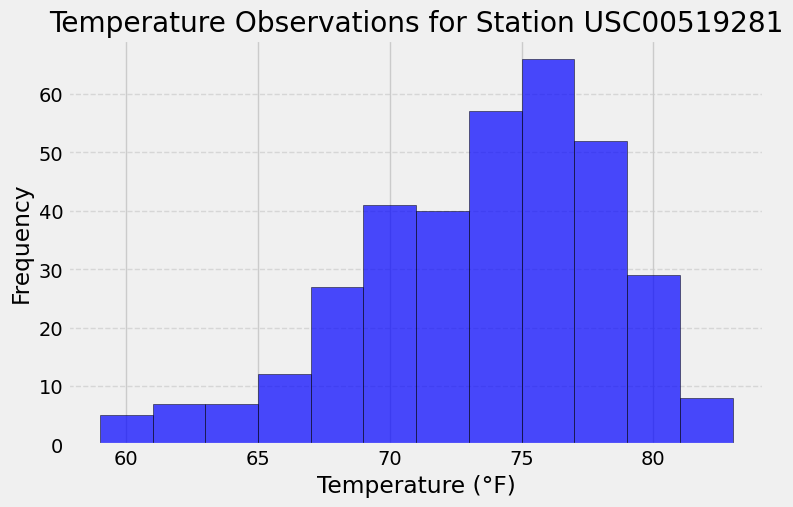

In [69]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# 12 month query
temp_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago)\
    .all()

# Convert query results into a list
temperatures = [temp[0] for temp in temp_data]

# Plot histogram 
plt.figure(figsize=(8, 5))
plt.hist(temperatures, bins=12, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Close Session

In [70]:
# Close Session
session.close()